# AI Agent: Workflow vs Agent (Part-5)

# Table of Contents
1. Agents Vs Workflows
- 1.1 When (and When Not) to Use Agents
- 1.2 When and How to Use Frameworks
2. Building Blocks
- 2.1 Set up
- 2.2 The Augmented LLM
3. Workflow
- 3.1 Prompt Chaining
- 3.2 Parallelization
- 3.3 Routing
- 3.4 Orchestrator-Worker
- 3.5 Evaluator-Optimizer
4. Agent
5. Combining and Customizing these Patterns
6. Conclusion

-  Phân biệt quy trình làm việc AI và tác nhân AI
-  Đi sâu vào quy trình làm việc AI
-  Khám khá khái niệm tác nhân AI và sự khác biệt giữa chúng

# 1. Agents Vs Workflows

Agent: hệ thống tự động, độc lập trong thời gian dài, sử dụng nhiều công cụ khác nhau để hoàn thành các nhiệm vụ phức tạp

Phân biệt:
- Workflow: quy trình làm việc là hệ thống, trong đó các LLM và công cụ được điêu phối thông qua các pipline đã được xác định trước
- Agent: tác nhân là hệ thống trong đó LLM tự động điều khiển các quy trình và cách sử dụng công cụ của riêng mình, đồng thời duy trì kiểm soát cách chúng hoàn thành nhiệm vụ

Hình dung:

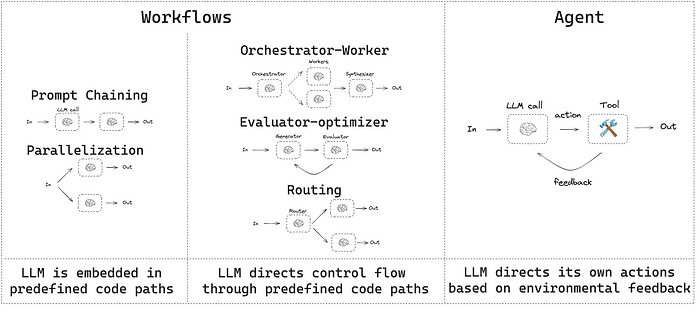

## 1.1 When (and When Not) to Use Agents
- khi phát triển ứng dụng với LLM, bắt đầu với giải pháp đơn giản nhất, chỉ áp dụng độ phức tạp khi cần thiết
- Các hệ thống agent cấp cao giúp cải thiện kết quả, đồng nghĩa chi phí thời gian tăng lên
- Workflow cung cấp khả năng dự đoán và tính nhất quán cho các tác vụ được cấu trúc tốt
- Agent phù hợp với các tình huống đòi hỏi sự linh hoạt và khả năng ra quyết định dựa trên mô hình ở quy mô lớn
- Hầu hết với nhiều ứng dụng, sử dụng lệnh gọi LLM riêng lẻ thường là đủ

## 1.2 When and How to Use Frameworks
- LangGraph
- ...

Khuyến khích: dùng API LLM trực tiếp vì chỉ cần vài dòng mã là đã có thể giải quyết, nếu sử dụng framwork hãy đảm bảo hiểu

# 2. Building Blocks

## 2.1 Set up

In [2]:
import os
import getpass

from langchain_anthropic import ChatAnthropic

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

## 2.2 The Augmented LLM
Nền tảng của Agentic system là một LLM được tăng cường với các tính năng bổ trợ như RAG, tools và Memory buffer

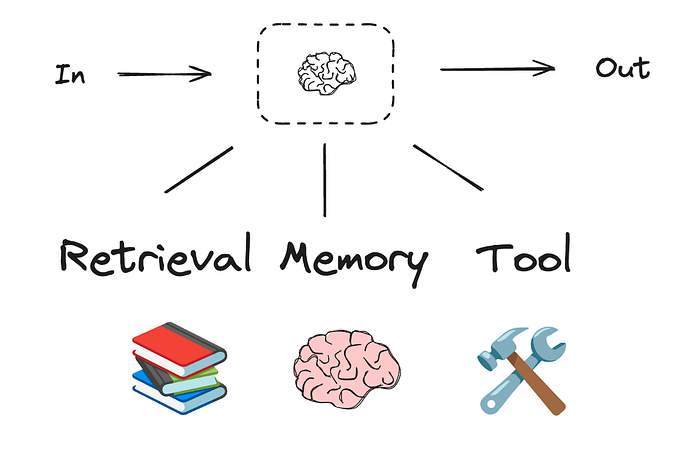

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

# 3. Workflow

## 3.1 Prompt Chaining
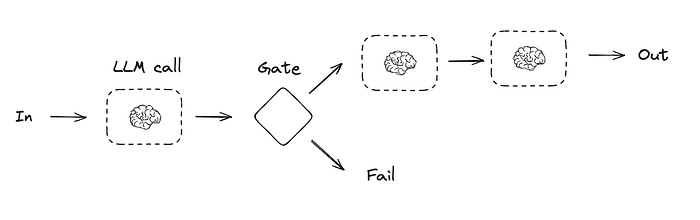

Nhắc lại:
- áp dụng workflow nếu quy trình rõ ràng và cố đinh
- sử dụng agent khi cần sự linh hoạt trong điều khiển và đánh đổi thời gian để đạt được độ chính xác cao hơn

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes
def generate_joke(state: State):
    "First LLM call to generate a joke"
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    "Gate function to check if the joke has a punchline"
    # Simple check - Does the joke contain "?" or !
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    "Second LLM call to improve the joke"
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state["joke"]}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add surprising twist to this joke: {state["imporved_joke"]}")
    return {"final_joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke",
    check_punchline,
    {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow graph
display(Image(chain.to_graph().draw_mermaid_pnd()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke: ", state["joke"])

if "improved_joke" in state:
    print(f"Improved joke: {state["improved_joke"]}")
    print(f"Final joke: {state["final_joke"]}")

else:
    print("Joke fail quality gate - no punchline detected.")

## 3.2 Parallelization
- Với tính năng song song, LLM có thể hoạt động đồng thời trên một tác vụ
- Song song hóa hiệu quả khi tác vụ được chia thành các tác vụ con và có thể chạy đồng thời để tăng tốc thời gian

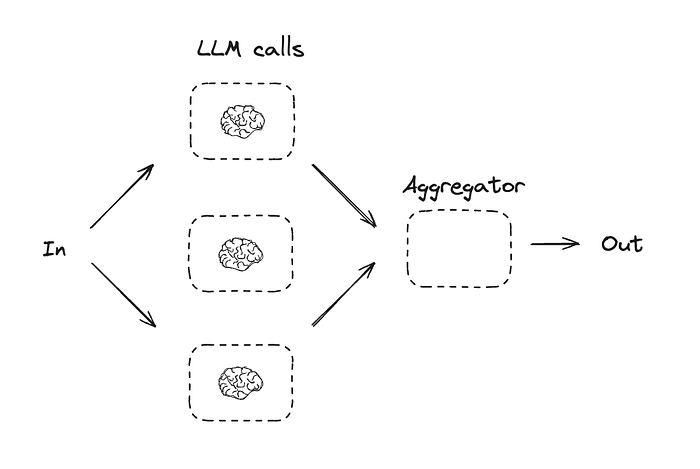

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Nodes
def call_llm_1(state: State):
    "First LLM call to generate a joke"
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    "Second LLM call to generate a story"
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    "Third LLM call to generate a poem"
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke and story into a single output"""
    combined = f"Here's a story, joke and poem about {state['topic']}:\n\n"
    combined += f"Story: {state['story']}\n\n"
    combined += f"Poem: {state['poem']}\n\n"
    return {"combined_output": combined}

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge(call_llm_1, "aggregator")
parallel_builder.add_edge(call_llm_2, "aggregator")
parallel_builder.add_edge(call_llm_3, "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

# Show workflow graph
display(Image(parallel_workflow.to_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])


## 3.3 Routing
Phân loại dữ liệu đầu vào và chuyển hướng nó đến tác vụ tiếp theo

Khi nào nên dùng?
- định tuyến hoạt động tốt với các tác vụ phức tạp, trong đó nhiều danh mục riêng biệt được xử lý tốt hơn riêng biệt và có thể xử lý phân loại chính xác bằng LLM hoặc mô hình/thuật toán phân loại truyền thống
  
vd:
- chuyển hướng câu hỏi người dùng qua nhân viên là con người
- phân loại câu hỏi khó hơn cho mô hình lớn, dễ hơn cho mô hình nhỏ hơn

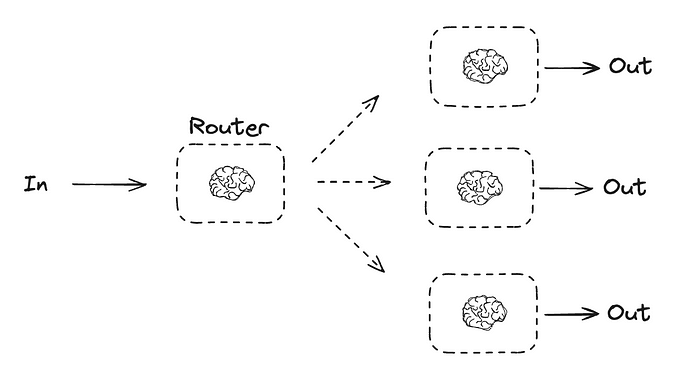

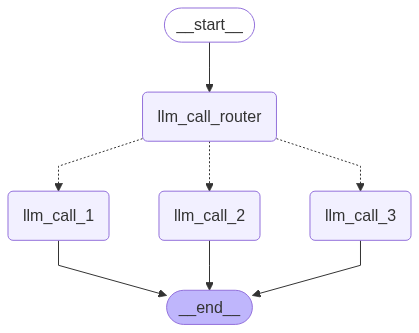

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from typing_extensions import TypedDict
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None,
        description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def call_llm_1(state: State):
    "Write a story"
    result = llm.invoke(state["input"])
    return {"output": result.content}

def call_llm_2(state: State):
    "Write a joke"
    result = llm.invoke(state["input"])
    return {"output": result.content}

def call_llm_3(state: State):
    "Write a poem"
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    "Route the input to the appropriate node"
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke([
        SystemMessage(content="Route the input to story, joke, or poem based on the user's request"),
        HumanMessage(content=state["input"])
    ])
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit
    if state["decision"] == "story":
        return "call_llm_1"
    elif state["decision"] == "joke":
        return "call_llm_2"
    elif state["decision"] == "poem":
        return "call_llm_3"
    
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", call_llm_1)
router_builder.add_node("llm_call_2", call_llm_2)
router_builder.add_node("llm_call_3", call_llm_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {   # Name returned by route_decision: Name of the next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3"
    }
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

## 3.4 Orchestrator-Worker
Với orchestrator-worker, orchestrator chia nhỏ một nhiệm vụ và phân công từng nhiệm vụ nhỏ cho các worker.

Trong công việc của Orchestrator-Worker, LLM trung tâm sẽ giao việc cho các LLM-worker và tổng hợp kết quả của chúng

Khi nào nên sử dụng quy trình làm việc này?
- Rất phù hợp cho các tác vụ phức tạp không thể dự đoán các tác vụ cần thiết
- Khác với làm việc song song, các tác vụ không được xác định trước mà là được bộ điều phối xác định dựa trên dữ liệu đầu vào cụ thể
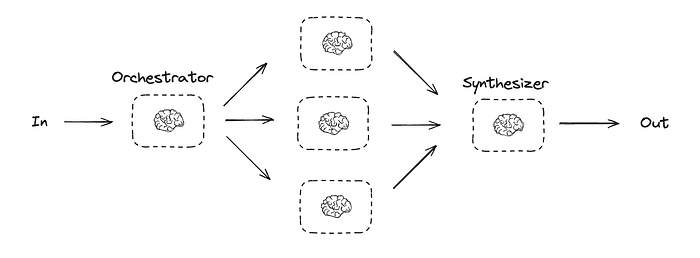

In [6]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

**Creating Workers in LangGraph**

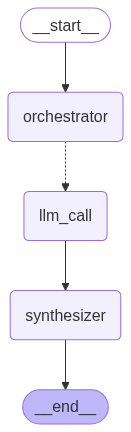

In [ ]:
from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## 3.5 Evaluator-Optimizer
Trong quy trình đánh giá-tối ưu hóa, một lệnh gọi LLM sẽ tạo ra phản hồi trong khi lệnh gọi khác sẽ cung cấp đánh giá và phản hồi trong một vòng lặp.

Khi nào nên sử dụng quy trình làm việc này: 
- Quy trình làm việc này đặc biệt hiệu quả khi chúng ta có tiêu chí đánh giá rõ ràng và khi việc tinh chỉnh lặp lại mang lại giá trị đo lường được. 
- Hai dấu hiệu của sự phù hợp tốt là, thứ nhất, phản hồi của LLM có thể được cải thiện rõ rệt khi con người đưa ra phản hồi: và thứ hai, LLM có thể cung cấp phản hồi như vậy. Điều này tương tự như quy trình viết lặp lại mà một người viết có thể trải qua khi tạo ra một tài liệu hoàn chỉnh.

**Examples where evaluator-optimizer is useful:**
- Biên dịch văn học có những sắc thái mà dịch giả LLM có thể không nắm bắt được ngay từ đầu, nhưng người đánh giá LLM có thể đưa ra những lời phê bình hữu ích.
- Nhiệm vụ tìm kiếm phức tạp đòi hỏi nhiều vòng tìm kiếm và phân tích để thu thập thông tin toàn diện, trong đó người đánh giá sẽ quyết định xem có cần thực hiện thêm tìm kiếm hay không.

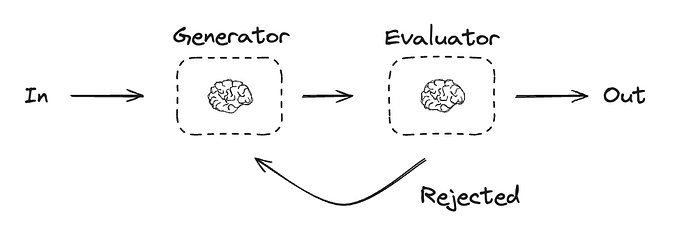

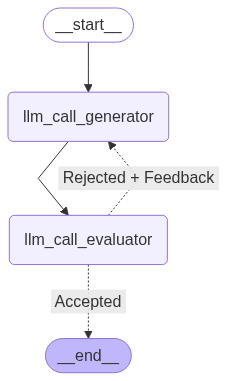

In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"
    
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

# 4. Agent
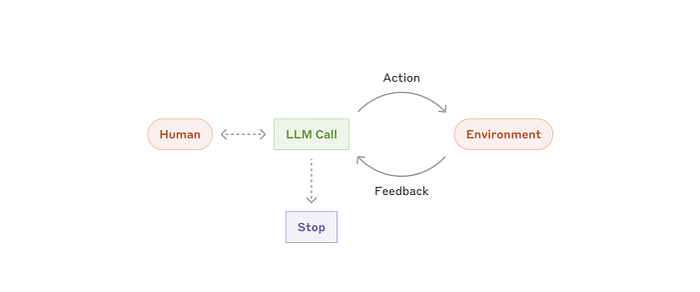

***Các tác nhân có thể xử lý các tác vụ phức tạp, nhưng việc triển khai chúng thường đơn giản. Họ thường chỉ là các LLM sử dụng các công cụ dựa trên phản hồi môi trường theo vòng lặp. Do đó, việc thiết kế bộ công cụ và tài liệu hướng dẫn một cách rõ ràng và chu đáo là rất quan trọng.***

When to use agents: 
- Tác nhân có thể được sử dụng cho bài toán mở, trong đó khó hoặc không thể dự đoán số bước cần thiết và không thể lập trình bằng những bước cố định
- LLM có khả năng hoạt động trong nhiều lượt, và bạn phải có một mức độ tin tưởng nhất định vào khả năng của nó
- Tính tự chủ của tác nhân khiến chúng trở nên lý tưởng để mở rộng quy mô tác vụ trong môi trường đáng tin cậy

Bản chất tự chủ của các tác nhân đồng nghĩa với chi phí cao hơn và khả năng xảy ra lỗi phức tạp. Chúng tôi khuyến nghị nên thử nghiệm rộng rãi trong môi trường sandbox, cùng với các biện pháp bảo vệ phù hợp

**Examples where agents are useful:**
- Các ví dụ sau đây là triển khai đơn giản: một tác nhân mã hóa để giải quyết cho các tác vụ SWE-bench, bao gồm việc chỉnh sửa nhiều tệp dựa trên mô tả tác vụ
- Triển khai tham chiếu "sử dụng máy tính" trong đó Claude sử dụng máy tính để hoàn thành các tác vụ.

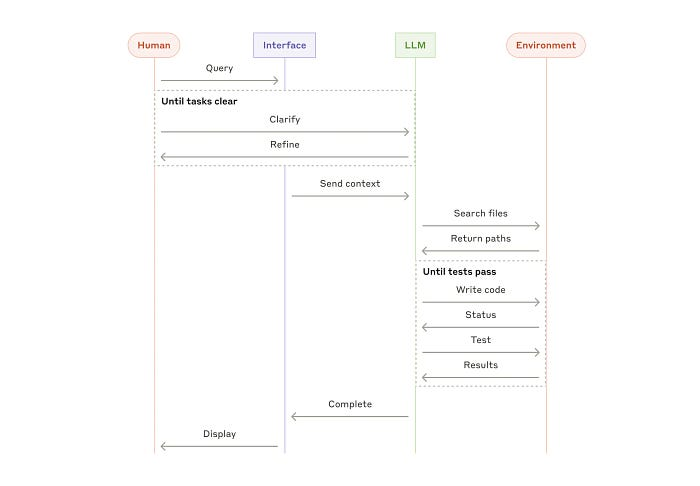

In [ ]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers."""
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds two numbers."""
    return a + b

@tool
def divide(a: int, b: int) -> int:
    """Divides two numbers."""
    if b == 0:
        raise ValueError("Cannot divide by zero")
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

# 5. Combining and Customizing these Patterns

Tác nhân AI và quy trình làm việc (workflow) bổ sung cho nhau và có thể được tích hợp để đạt được mục tiêu tối ưu, đặc biệt trong ứng dụng thực tế phức tạp:
- Enhanced automation: Tự động hóa nâng cao
- Scability (khả năng mở rộng)
- Resilience and adaptability (khả năng phục hồi và thích ứng)

ví dụ: tích hợp AI agent trong quy trình làm việc và sản xuất

In a smart manufacturing system:
- AI Agents: theo dõi hiệu suất thiết bị, dự đoán nhu cầu bảo trì và tối ưu hóa lịch trình sản xuất
- AI agentic workflow: giám sát việc mua sắm nguyên liệu thô, sắp xếp sản xuất, đảm bảo chất lượng và hậu cần, đảm bảo quá trình chuyển đổi liền mạch từ nguyên liệu thô đến giao sản phẩm  

# 6. Conclusion

Thành công với LLM không đến từ hệ thống phức tạp nhất, mà là từ hệ thống phù hợp nhất.
- Bắt đầu với prompt đơn giản → tối ưu qua đánh giá kỹ lưỡng → chỉ thêm agent đa bước nếu cách đơn giản không đủ.

Khi xây dựng agent, tuân thủ 3 nguyên tắc:
- Giữ thiết kế đơn giản.
- Minh bạch kế hoạch hành động của agent.
- Xây dựng giao diện agent-computer (ACI) rõ ràng, có tài liệu và kiểm thử kỹ.

Cuối cùng, framework giúp khởi đầu nhanh, nhưng khi triển khai thực tế, nên giảm trừu tượng và dùng các thành phần cơ bản để đảm bảo hiệu năng và dễ bảo trì.